In [133]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax

In [134]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):

    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))

    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    return samples

In [135]:
def sm_loss(params, samples):

    mu = params["mu"]
    L = params["L"]
    prec = L @ L.T

    centered = samples - mu
    prec2 = prec @ prec
    quad_terms = jnp.sum((centered @ prec2) * centered, axis=1)

    loss = 0.5 * jnp.mean(quad_terms) - jnp.trace(prec)
    
    return loss

In [136]:
def optimize_score_matching_with_tracking(samples, true_mu, true_cov, n_steps=1000, lr=1e-2, seed=0):
    d = samples.shape[1]
    key = jax.random.PRNGKey(seed)
    key_mu, key_L = jax.random.split(key)

    mu_init = jax.random.normal(key_mu, shape=(d,))
    L_init = jnp.eye(d) + 0.01 * jax.random.normal(key_L, shape=(d, d))
    L_init = jnp.tril(L_init)

    params = {"mu": mu_init, "L": L_init}
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    loss_grad_fn = jax.value_and_grad(sm_loss)

    history = {
        "loss": [],
        "mu_l2": [],
        "cov_l2": [],
        "cov_fro": [],
    }

    for step in range(n_steps):
        loss_val, grads = loss_grad_fn(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        params["L"] = jnp.tril(params["L"])  # keeping L lower-triangular

        # tracking
        mu_hat = params["mu"]
        prec_hat = params["L"] @ params["L"].T
        cov_hat = jnp.linalg.inv(prec_hat)

        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_hat))
        history["cov_l2"].append(jnp.linalg.norm(true_cov - cov_hat, ord=2))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_hat, ord='fro'))

    return params, history


In [137]:
mu = jnp.array([0.0])

cov = jnp.array([
[1.0]
])

In [138]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)

params_hat, history = optimize_score_matching_with_tracking(samples, mu, cov, n_steps=1200, lr=1e-2, seed = 0)

mu_hat = params_hat["mu"]
precision_hat = params_hat["L"] @ params_hat["L"].T
cov_hat = jnp.linalg.inv(precision_hat)

In [139]:
jnp.set_printoptions(precision=4, suppress=True)

print(jnp.round(mu, 4), "\n\n", jnp.round(mu_hat, 4), jnp.linalg.norm(mu - mu_hat), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(cov_hat, 4), jnp.linalg.norm(cov - cov_hat), "\n\n\n")

[0.] 

 [-0.0224] 0.022365391 



[[1.]] 

 [[1.0069]] 0.006903529 





In [140]:
history_np = {k: np.array(v) for k, v in history.items()}

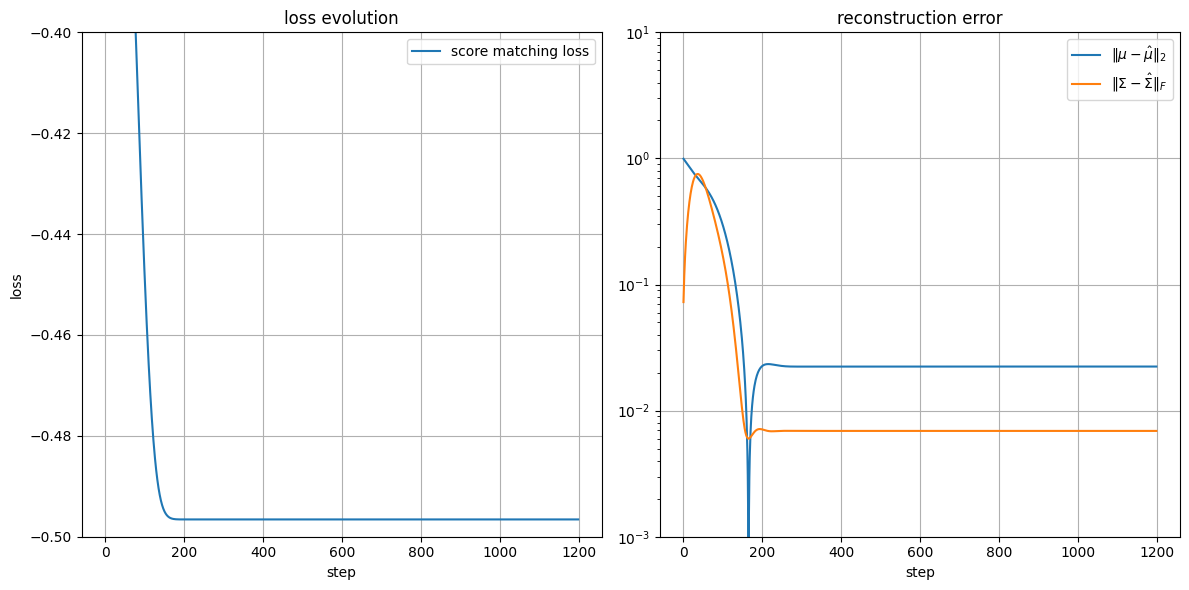

In [148]:

ymin_recon = -0.5
ymax_recon = -0.4
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.ylim(ymin_recon, ymax_recon)
# plt.yscale("log")
plt.xlabel("step")
plt.ylabel("loss")
plt.title("loss evolution")
plt.grid(True)
plt.legend()


ymin_recon = 1e-3
ymax_recon = 10.0
plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"], label=r"$\| \mu - \hat{\mu} \|_2$")
#plt.plot(history_np["cov_l2"], label=r"$\| \Sigma - \hat{\Sigma} \|_2$")
plt.plot(history_np["cov_fro"], label=r"$\| \Sigma - \hat{\Sigma} \|_F$")
plt.ylim(ymin_recon, ymax_recon)
plt.yscale("log")
plt.xlabel("step")
plt.title("reconstruction error")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
history_np["mu_l2"]

array([0.994 , 0.984 , 0.9741, ..., 0.0224, 0.0224, 0.0224],
      shape=(1200,), dtype=float32)

In [ ]:
history_np["cov_fro"]

array([0.0726, 0.0951, 0.1182, ..., 0.0069, 0.0069, 0.0069],
      shape=(1200,), dtype=float32)